In [1]:
# TEAM SixSeven (Introductory Options Hackathon)

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as si
from scipy.stats import percentileofscore
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

plt.style.use('default')

In [2]:
# ticker and live option prices (fetched from yfinance website manually, not automated)
TICKER = "GOOGL"
OPTION_TYPE = "call"
STRIKE_PRICE = 350.0
MARKET_PRICE = 10.10
EXPIRY_DATE = "2026-02-20" # around 45 days from now
RISK_FREE_RATE = 0.0414 # current US treasury rate

# current America date
est_date_time = datetime.now(ZoneInfo("America/New_York"))

In [3]:
# fetching ticker prices data of the past 12 months
def get_data(ticker):
  end_date = est_date_time.date()
  start_date = end_date - timedelta(days=365)
  data = yf.download(ticker, start=start_date, end=end_date)

  # yfinance gives two levels of headers, remove the second level
  if isinstance(data.columns, pd.MultiIndex):
    data = data.xs(ticker, axis=1, level=1) if ticker in data.columns.levels[1] else data

  data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
  data['Vol_21d'] = data['Log_Ret'].rolling(21).std() * np.sqrt(252)

  return data.dropna()

df = get_data(TICKER)
df.head()

/tmp/ipython-input-1133083619.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Log_Ret,Vol_21d
Date,,,,,,,
2025-02-14,184.507401,185.672834,183.600962,184.338066,20448400,-0.004901,0.384627
2025-02-18,183.053101,185.234560,181.031021,184.875963,29916700,-0.007913,0.383079
2025-02-19,184.547241,184.736502,182.873787,183.351926,19549400,0.008129,0.379357
2025-02-20,183.839996,184.587070,182.007178,184.079066,20441500,-0.003840,0.376364
2025-02-21,178.959106,184.616940,178.381367,184.427679,35199200,-0.026908,0.384496


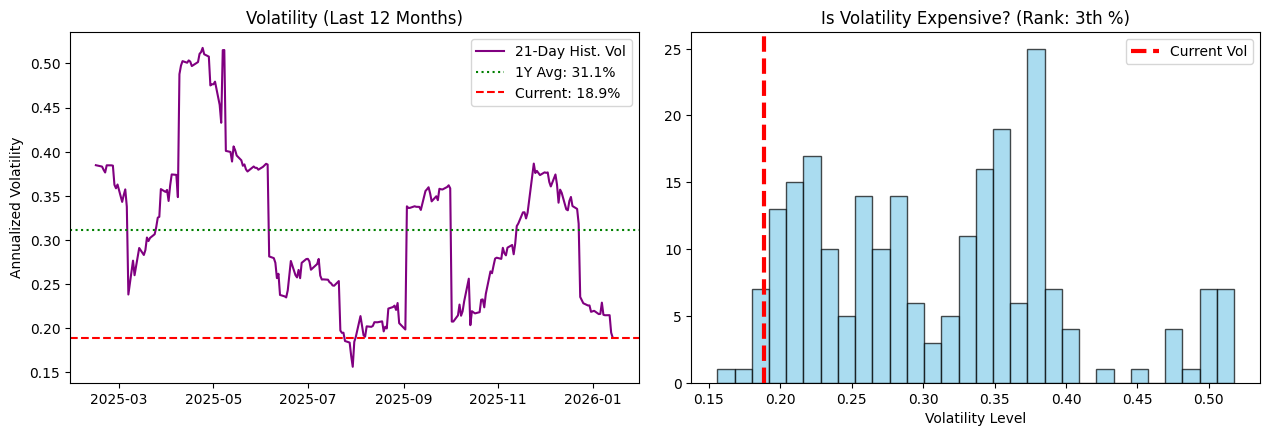

Volatility verdict: CHEAP (lower volatility than usual)


In [4]:
# Visualizing Volatility
current_vol = df['Vol_21d'].iloc[-1]
mean_vol = df['Vol_21d'].mean()

vol_percentile = percentileofscore(df['Vol_21d'], current_vol)
vol_verdict = ""
if (vol_percentile < 20):
  vol_verdict = "CHEAP (lower volatility than usual)"
elif (vol_percentile > 80):
  vol_verdict = "EXPENSIVE (higher volatility than usual)"
else:
  vol_verdict = "FAIR"

# plt.style.use('ggplot')
ax1 = plt.subplot(1,2,1)
ax1.plot(df.index, df['Vol_21d'], color='purple', label='21-Day Hist. Vol')
ax1.axhline(mean_vol, color='green', linestyle=':', label=f'1Y Avg: {mean_vol:.1%}')
ax1.axhline(current_vol, color='red', linestyle='--', label=f'Current: {current_vol:.1%}')
ax1.set_ylabel("Annualized Volatility")
ax1.set_title("Volatility (Last 12 Months)")
ax1.legend()

ax2 = plt.subplot(1,2,2)
ax2.hist(df['Vol_21d'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(current_vol, color='red', linewidth=3, linestyle='--', label='Current Vol')
ax2.set_title(f"Is Volatility Expensive? (Rank: {vol_percentile:.0f}th %)")
ax2.set_xlabel("Volatility Level")
ax2.legend()

plt.tight_layout(rect=[0, 0.07, 2, 1])
plt.show()

print(f'Volatility verdict: {vol_verdict}')

In [5]:
# Option pricing using the Black Scholes Model and Greeks calculation
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
  """
  Inputs:
  S: Spot Price (Current Stock Price)
  K: Strike Price
  T: Time to Expiry (in years)
  r: risk-free interest rate
  sigma: volatility
  """
  
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  
  # Calculations based on Option Type
  if option_type == 'call':
    price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    delta = si.norm.cdf(d1)
    theta = (- (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2)) / 365.0
  else: # Put
    price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    delta = si.norm.cdf(d1) - 1
    theta = (- (S * sigma * si.norm.pdf(d1)) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2)) / 365.0

  # Vega (Same for Call and Put)
  vega = (S * np.sqrt(T) * si.norm.pdf(d1)) / 100.0
  
  return price, delta, theta, vega

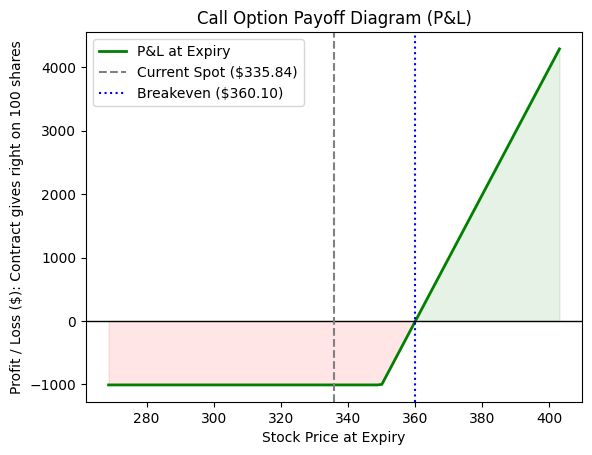

In [6]:
current_spot = df['Close'].iloc[-1]

# time to expiry
expiry_dt = datetime.strptime(EXPIRY_DATE, "%Y-%m-%d")
days_to_expiry = (expiry_dt.date() - est_date_time.date()).days
T_years = days_to_expiry / 365.0

model_price, delta, theta, vega = black_scholes_greeks(S=current_spot, 
                                                       K=STRIKE_PRICE, 
                                                       T=T_years, 
                                                       r=RISK_FREE_RATE, 
                                                       sigma=current_vol, 
                                                       option_type=OPTION_TYPE)

shares_to_hedge = int(round(abs(delta) * 100))
hedge_action = "SHORT" if delta > 0 else "BUY"

ax3 = plt
price_range = np.linspace(current_spot * 0.8, current_spot * 1.2, 100)
payoffs = [100*(max(p - STRIKE_PRICE, 0) - MARKET_PRICE) for p in price_range]

ax3.plot(price_range, payoffs, color='green', linewidth=2, label='P&L at Expiry')
ax3.fill_between(price_range, payoffs, 0, where=(np.array(payoffs) > 0), color='green', alpha=0.1)
ax3.fill_between(price_range, payoffs, 0, where=(np.array(payoffs) < 0), color='red', alpha=0.1)
ax3.axhline(0, color='black', linewidth=1)
ax3.axvline(current_spot, color='grey', linestyle='--', label=f'Current Spot (${current_spot:.2f})')
ax3.axvline(STRIKE_PRICE + MARKET_PRICE, color='blue', linestyle=':', label=f'Breakeven (${STRIKE_PRICE + MARKET_PRICE:.2f})')
ax3.title("Call Option Payoff Diagram (P&L)")
ax3.xlabel("Stock Price at Expiry")
ax3.ylabel("Profit / Loss ($): Contract gives right on 100 shares")
ax3.legend()

In [7]:
print("="*50)
print(f'{" "*20}CONSULTING MEMO{" "*20}')
print("="*50)
print(f"TO:      Portfolio Manager")
print(f"DATE:    {datetime.now().strftime('%Y-%m-%d')}")
print(f"SUBJECT: Recommendation on {TICKER} ${STRIKE_PRICE} {OPTION_TYPE.upper()}")
print("-"*50)

print(f"\nSUMMARY:")
print(f"Model indicates that option premiums are currently {vol_verdict}.")
print(f"Current Volatility ({current_vol:.1%}) is in the {vol_percentile:.0f}th percentile of the 12-month range.")

print(f"\nPRICING DISCREPANCY:")
print(f"{'Metric':<20} | {'Value':<15}")
print(f"{'-'*38}")
print(f"{'Model Fair Value':<20} | ${model_price:.2f}")
print(f"{'Market Price':<20} | ${MARKET_PRICE:.2f}")
diff = model_price - MARKET_PRICE
print(f"{'Discrepancy':<20} | ${diff:.2f} ({'Undervalued' if diff > 0 else 'Overvalued'})")

print(f"\nRISKS AND GREEKS:")
print(f"- DELTA ({delta:.2f}): For every $1 {TICKER} moves up, this option gains ${delta:.2f}.")
print(f"  Exposure equivalent to owning {int(delta*100)} shares of stock.")
print(f"- THETA ({theta:.2f}): We lose ${abs(theta):.2f} per day due to time decay.")
print(f"- VEGA  ({vega:.2f}): If Volatility spikes 1%, option value increases by ${vega:.2f}.")

print(f"\nHEDGING RECOMMENDATION (DELTA NEUTRAL)")
print(f"To eliminate directional risk:")
print(f"ACTION: Buy 1 Option Contract")
print(f"HEDGE:  {hedge_action} {shares_to_hedge} shares of {TICKER} stock.")
print("="*50)

                    CONSULTING MEMO                    
TO:      Portfolio Manager
DATE:    2026-01-15
SUBJECT: Recommendation on GOOGL $350.0 CALL
--------------------------------------------------

SUMMARY:
Model indicates that option premiums are currently CHEAP (lower volatility than usual).
Current Volatility (18.9%) is in the 3th percentile of the 12-month range.

PRICING DISCREPANCY:
Metric               | Value          
--------------------------------------
Model Fair Value     | $3.28
Market Price         | $10.10
Discrepancy          | $-6.82 (Overvalued)

RISKS AND GREEKS:
- DELTA (0.28): For every $1 GOOGL moves up, this option gains $0.28.
  Exposure equivalent to owning 27 shares of stock.
- THETA (-0.10): We lose $0.10 per day due to time decay.
- VEGA  (0.35): If Volatility spikes 1%, option value increases by $0.35.

HEDGING RECOMMENDATION (DELTA NEUTRAL)
To eliminate directional risk:
ACTION: Buy 1 Option Contract
HEDGE:  SHORT 28 shares of GOOGL stock.


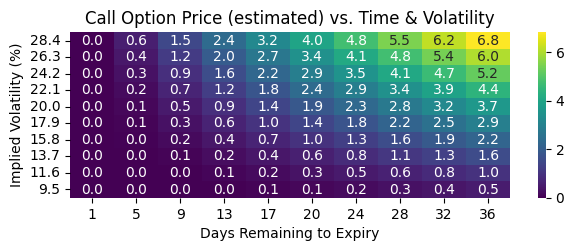

In [8]:
# sensitivity analysis with days to expiry and volatility range

days_range = np.linspace(T_years * 365, 1, 10)
vol_range = np.linspace(current_vol * 0.5, current_vol * 1.5, 10)
sensitivity_matrix = np.zeros((10, 10))

for i, d in enumerate(days_range):
  for j, v in enumerate(vol_range):
    # call price for each pair
    p, _, _, _ = black_scholes_greeks(current_spot, STRIKE_PRICE, d/365.0, RISK_FREE_RATE, v, 'call')
    sensitivity_matrix[j, i] = p

ax3 = plt.subplot(2, 1, 2)
# Reverse days range for display (Today -> Expiry)
sns.heatmap(sensitivity_matrix, xticklabels=np.round(days_range, 0).astype(int), 
            yticklabels=np.round(vol_range*100, 1), annot=True, fmt=".1f", cmap="viridis", ax=ax3)
ax3.set_title("Call Option Price (estimated) vs. Time & Volatility")
ax3.set_xlabel("Days Remaining to Expiry")
ax3.set_ylabel("Implied Volatility (%)")
ax3.invert_xaxis()
ax3.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()